**Setup**

In [4]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

# Define the S3 location of the model
# model_location = 's3://csml-data-bucket/output/pytorch-training-2024-11-14-01-19-57-379/output/model.tar.gz' #SimpleCNN
model_location = 's3://csml-data-bucket/output/pytorch-training-2024-11-24-18-22-30-126/output/model.tar.gz' #ResNet-50
# model_location = 's3://csml-data-bucket/output/pytorch-training-2024-11-17-22-29-53-901/output/model.tar.gz' #EfficientNet

# inf_name = 'inference.py' #SimpleCNN
inf_name = 'inference_resnet50.py' #ResNet-50
# inf_name = 'inference_efficient_net.py' #EfficientNet

# SageMaker session
sagemaker_session = sagemaker.Session()

# IAM role for SageMaker
role = 'AmazonSageMaker-ExecutionRole-20240830T235279'

# Define the model
pytorch_model = PyTorchModel(
    model_data=model_location,
    role=role,
    entry_point=inf_name,  # We'll define this script next
    framework_version='2.0.0',          # Updated to PyTorch 2.0.0
    py_version='py310', 
    source_dir='/home/ec2-user/SageMaker/code/',  # Directory containing inference.py
    sagemaker_session=sagemaker_session
)


**Deploy the model to endpoint**

In [5]:
predictor = pytorch_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.g4dn.4xlarge'  # Or another instance type from above
)



-----------!

**Below is for testing**

In [17]:
import boto3
from PIL import Image
import io
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer  # Import JSONDeserializer

# Initialize S3 client
s3 = boto3.client('s3')

# S3 bucket and image details
bucket_name = 'csml-data-bucket'
# image_key = 'preprocessed/validation/no_birds/2023_0527_120704_001.JPG'
image_key = 'preprocessed/validation/birds/DSCF0811.JPG'

# Download the image from S3 to a local file
s3.download_file(bucket_name, image_key, 'downloaded_image.jpg')

# Open the downloaded image and verify it's a valid JPEG file
try:
    with open('downloaded_image.jpg', 'rb') as f:
        img_bytes = f.read()

    # Check if the image can be opened and processed
    img = Image.open(io.BytesIO(img_bytes))

    # Ensure the file is a JPEG image
    if img.format != 'JPEG':
        raise ValueError(f"File format is {img.format}, expected JPEG.")

    # Print image details for validation
    print(f"Image format: {img.format}, size: {img.size}")

    # Optional: Print the first few bytes
    print(f"First 10 bytes of img_bytes: {img_bytes[:10]}")

except Exception as e:
    print(f"Error opening or verifying image: {e}")
    raise  # Don't proceed if it's not a valid JPEG

# Configure the predictor to send raw bytes and receive JSON responses
predictor.serializer = IdentitySerializer(content_type='image/jpeg')
predictor.deserializer = JSONDeserializer()  # Set the deserializer to JSONDeserializer

# If the image is valid, proceed with calling the SageMaker endpoint
try:
    print("Sending image to SageMaker endpoint for prediction...")
    response = predictor.predict(img_bytes)
    print(f"Predicted class: {response}")
except Exception as e:
    print(f"Error predicting: {e}")


Image format: JPEG, size: (224, 224)
First 10 bytes of img_bytes: b'\xff\xd8\xff\xe0\x00\x10JFIF'
Sending image to SageMaker endpoint for prediction...
Predicted class: {'predicted_class': 0, 'probabilities': [[0.9999998807907104, 7.456912953784922e-08]]}


**Below is with SimpleCNN**

Total images found: 268
Processed 50/268 images
Processed 100/268 images
Processed 150/268 images
Processed 200/268 images
Processed 250/268 images
Processed 268/268 images
              precision    recall  f1-score   support

       birds       0.69      0.99      0.81       134
    no_birds       0.97      0.56      0.71       134

    accuracy                           0.77       268
   macro avg       0.83      0.77      0.76       268
weighted avg       0.83      0.77      0.76       268



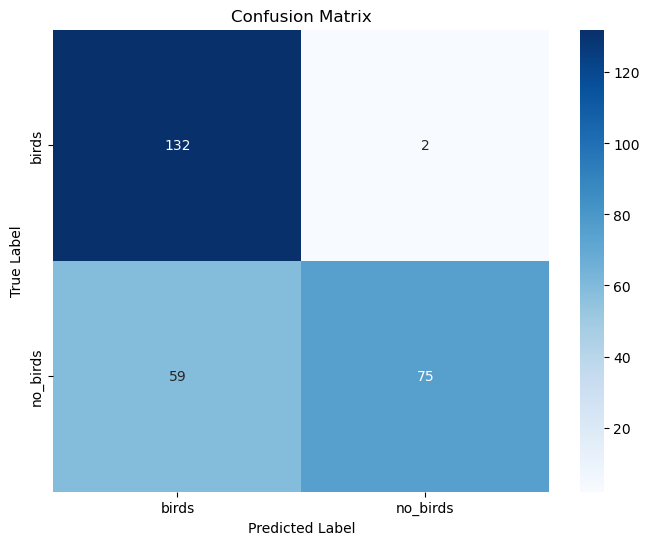

In [3]:
import boto3
import io
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import confusion_matrix, classification_report

# Initialize AWS clients
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3')

# Use your specific endpoint name
endpoint_name = 'pytorch-inference-2024-11-14-01-34-07-844'

# Initialize the predictor with your endpoint name
predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer('image/jpeg'),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

# S3 bucket and prefixes
bucket_name = 'csml-data-bucket'
validation_prefix = 'preprocessed/validation/'

def list_images_in_s3(bucket, prefix):
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    image_keys = []
    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_keys.append(key)
    return image_keys

# Get list of all image keys
image_keys = list_images_in_s3(bucket_name, validation_prefix)
print(f"Total images found: {len(image_keys)}")

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Map class names to numerical labels
class_names = ['birds', 'no_birds']
class_to_index = {'birds': 0, 'no_birds': 1}

for idx, image_key in enumerate(image_keys):
    # Extract the true label from the folder name
    # Assuming structure: preprocessed/validation/class_name/image.jpg
    true_label_name = image_key.split('/')[2]
    true_label = class_to_index.get(true_label_name)
    
    if true_label is None:
        print(f"Warning: Unrecognized class '{true_label_name}' in image {image_key}")
        continue  # Skip this image if the class is unrecognized

    true_labels.append(true_label)

    # Download the image from S3 to memory
    response = s3.get_object(Bucket=bucket_name, Key=image_key)
    img_bytes = response['Body'].read()

    # Send the image to the SageMaker endpoint
    try:
        prediction = predictor.predict(img_bytes)
        predicted_class = prediction['predicted_class']
        predicted_labels.append(predicted_class)
    except Exception as e:
        print(f"Error predicting image {image_key}: {e}")
        predicted_labels.append(None)  # Append None for failed predictions

    # Optional: Print progress
    if (idx + 1) % 50 == 0 or (idx + 1) == len(image_keys):
        print(f"Processed {idx + 1}/{len(image_keys)} images")

# Remove any entries with None in predicted_labels
valid_indices = [i for i, pred in enumerate(predicted_labels) if pred is not None]
true_labels_clean = [true_labels[i] for i in valid_indices]
predicted_labels_clean = [predicted_labels[i] for i in valid_indices]

# Compute confusion matrix
cm = confusion_matrix(true_labels_clean, predicted_labels_clean)

# Print classification report
report = classification_report(true_labels_clean, predicted_labels_clean, target_names=class_names)
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


**Below is with ResNet-50**

Total images found: 268
Processed 50/268 images
Processed 100/268 images
Processed 150/268 images
Processed 200/268 images
Processed 250/268 images
Processed 268/268 images
              precision    recall  f1-score   support

       birds       0.98      0.98      0.98       134
    no_birds       0.98      0.98      0.98       134

    accuracy                           0.98       268
   macro avg       0.98      0.98      0.98       268
weighted avg       0.98      0.98      0.98       268



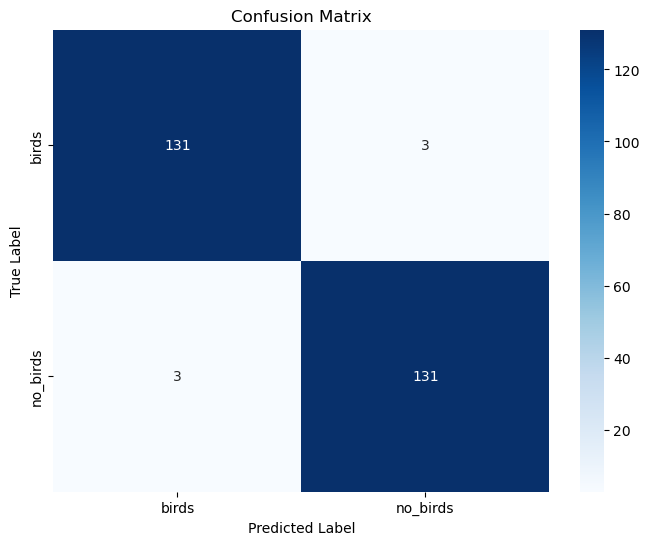

In [6]:
import boto3
import io
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import confusion_matrix, classification_report

# Initialize AWS clients
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3')

# Use your specific endpoint name
endpoint_name = 'pytorch-inference-2024-11-24-18-57-44-931'

# Initialize the predictor with your endpoint name
predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer('image/jpeg'),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

# S3 bucket and prefixes
bucket_name = 'csml-data-bucket'
validation_prefix = 'preprocessed/validation/'

def list_images_in_s3(bucket, prefix):
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    image_keys = []
    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_keys.append(key)
    return image_keys

# Get list of all image keys
image_keys = list_images_in_s3(bucket_name, validation_prefix)
print(f"Total images found: {len(image_keys)}")

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Map class names to numerical labels
class_names = ['birds', 'no_birds']
class_to_index = {'birds': 0, 'no_birds': 1}

for idx, image_key in enumerate(image_keys):
    # Extract the true label from the folder name
    # Assuming structure: preprocessed/validation/class_name/image.jpg
    true_label_name = image_key.split('/')[2]
    true_label = class_to_index.get(true_label_name)
    
    if true_label is None:
        print(f"Warning: Unrecognized class '{true_label_name}' in image {image_key}")
        continue  # Skip this image if the class is unrecognized

    true_labels.append(true_label)

    # Download the image from S3 to memory
    response = s3.get_object(Bucket=bucket_name, Key=image_key)
    img_bytes = response['Body'].read()

    # Send the image to the SageMaker endpoint
    try:
        prediction = predictor.predict(img_bytes)
        predicted_class = prediction['predicted_class']
        predicted_labels.append(predicted_class)
    except Exception as e:
        print(f"Error predicting image {image_key}: {e}")
        predicted_labels.append(None)  # Append None for failed predictions

    # Optional: Print progress
    if (idx + 1) % 50 == 0 or (idx + 1) == len(image_keys):
        print(f"Processed {idx + 1}/{len(image_keys)} images")

# Remove any entries with None in predicted_labels
valid_indices = [i for i, pred in enumerate(predicted_labels) if pred is not None]
true_labels_clean = [true_labels[i] for i in valid_indices]
predicted_labels_clean = [predicted_labels[i] for i in valid_indices]

# Compute confusion matrix
cm = confusion_matrix(true_labels_clean, predicted_labels_clean)

# Print classification report
report = classification_report(true_labels_clean, predicted_labels_clean, target_names=class_names)
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


**Below is EfficientNet**

Total images found: 268
Processed 50/268 images
Processed 100/268 images
Processed 150/268 images
Processed 200/268 images
Processed 250/268 images
Processed 268/268 images
              precision    recall  f1-score   support

       birds       0.83      0.99      0.90       134
    no_birds       0.98      0.80      0.88       134

    accuracy                           0.89       268
   macro avg       0.91      0.89      0.89       268
weighted avg       0.91      0.89      0.89       268



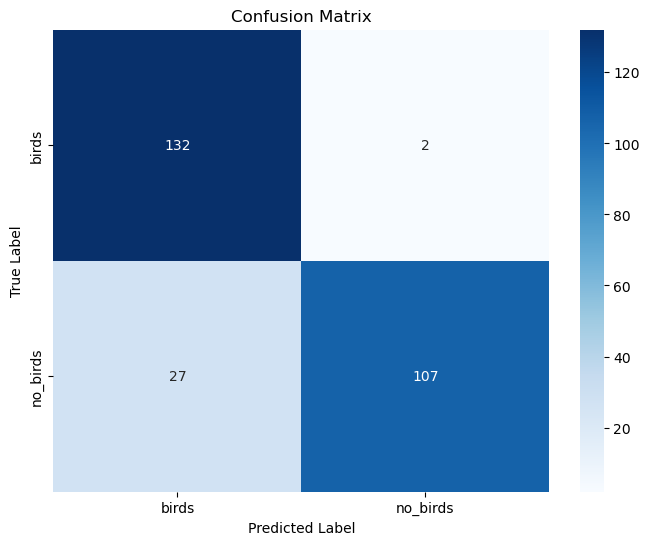

In [8]:
import boto3
import io
import os
import sagemaker
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import confusion_matrix, classification_report

# Initialize AWS clients
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3')

# Use your specific endpoint name (ensure this endpoint is updated with the EfficientNet model)
endpoint_name = 'pytorch-inference-2024-11-17-22-54-39-659'

# Initialize the predictor with your endpoint name
predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer('image/jpeg'),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

# S3 bucket and prefixes
bucket_name = 'csml-data-bucket'
validation_prefix = 'preprocessed/validation/'

def list_images_in_s3(bucket, prefix):
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

    image_keys = []
    for page in pages:
        for obj in page.get('Contents', []):
            key = obj['Key']
            if key.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_keys.append(key)
    return image_keys

# Get list of all image keys
image_keys = list_images_in_s3(bucket_name, validation_prefix)
print(f"Total images found: {len(image_keys)}")

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Map class names to numerical labels
# Ensure the class names match the classes in your dataset
# The classes are sorted alphanumerically by ImageFolder, so adjust accordingly
class_names = sorted(['birds', 'no_birds'])
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}
index_to_class = {idx: class_name for class_name, idx in class_to_index.items()}

for idx, image_key in enumerate(image_keys):
    # Extract the true label from the folder name
    # Assuming structure: preprocessed/validation/class_name/image.jpg
    true_label_name = image_key.split('/')[2]
    true_label = class_to_index.get(true_label_name)
    
    if true_label is None:
        print(f"Warning: Unrecognized class '{true_label_name}' in image {image_key}")
        continue  # Skip this image if the class is unrecognized

    true_labels.append(true_label)

    # Download the image from S3 to memory
    response = s3.get_object(Bucket=bucket_name, Key=image_key)
    img_bytes = response['Body'].read()

    # Send the image to the SageMaker endpoint
    try:
        prediction = predictor.predict(img_bytes)
        predicted_class_idx = prediction['predicted_class']
        predicted_labels.append(predicted_class_idx)
    except Exception as e:
        print(f"Error predicting image {image_key}: {e}")
        predicted_labels.append(None)  # Append None for failed predictions

    # Optional: Print progress
    if (idx + 1) % 50 == 0 or (idx + 1) == len(image_keys):
        print(f"Processed {idx + 1}/{len(image_keys)} images")

# Remove any entries with None in predicted_labels
valid_indices = [i for i, pred in enumerate(predicted_labels) if pred is not None]
true_labels_clean = [true_labels[i] for i in valid_indices]
predicted_labels_clean = [predicted_labels[i] for i in valid_indices]

# Compute confusion matrix
cm = confusion_matrix(true_labels_clean, predicted_labels_clean)

# Print classification report
report = classification_report(true_labels_clean, predicted_labels_clean, target_names=class_names)
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
